In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('TSLA.csv')

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [11]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2010-07-01 to 2022-05-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3000 non-null   float64
 1   High       3000 non-null   float64
 2   Low        3000 non-null   float64
 3   Close      3000 non-null   float64
 4   Adj Close  3000 non-null   float64
 5   Volume     3000 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 164.1 KB
None
              Open         High          Low        Close    Adj Close  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean    150.580895   153.939178   146.885623   150.523976   150.523976   
std     266.211294   272.371630   259.204230   265.919613   265.919613   
min       3.228000     3.326000     2.996000     3.160000     3.160000   
25%      21.171501    21.903001    20.361500    21.105499    21.105499   
50%      47.098000    47.921002    46.219000    47.1060

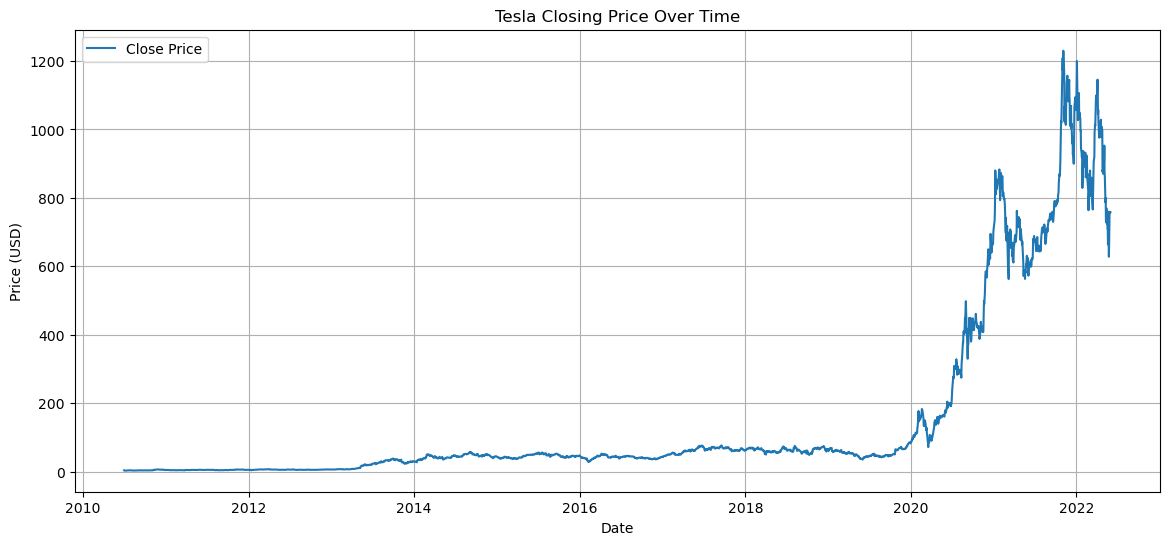

In [13]:
#Plot closing prices
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title('Tesla Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

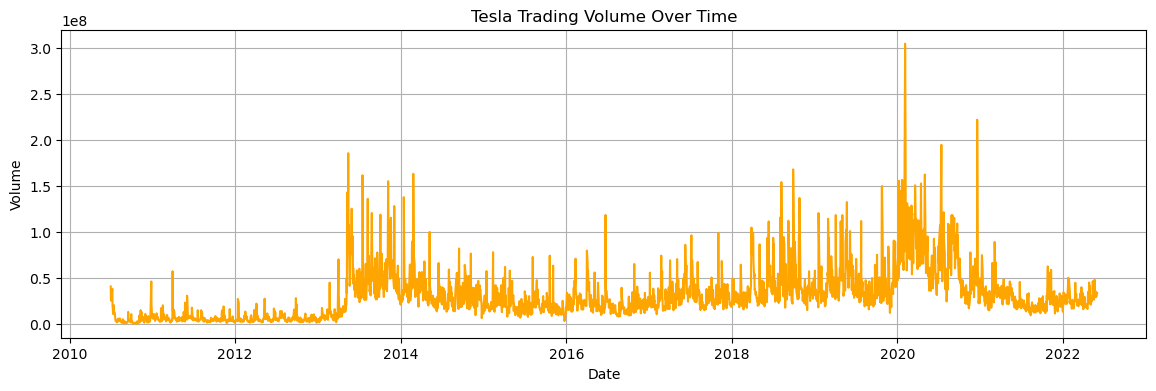

In [15]:
# Plot Volume
plt.figure(figsize=(14,4))
plt.plot(df['Volume'], color='orange')
plt.title('Tesla Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

In [17]:
# Moving Averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

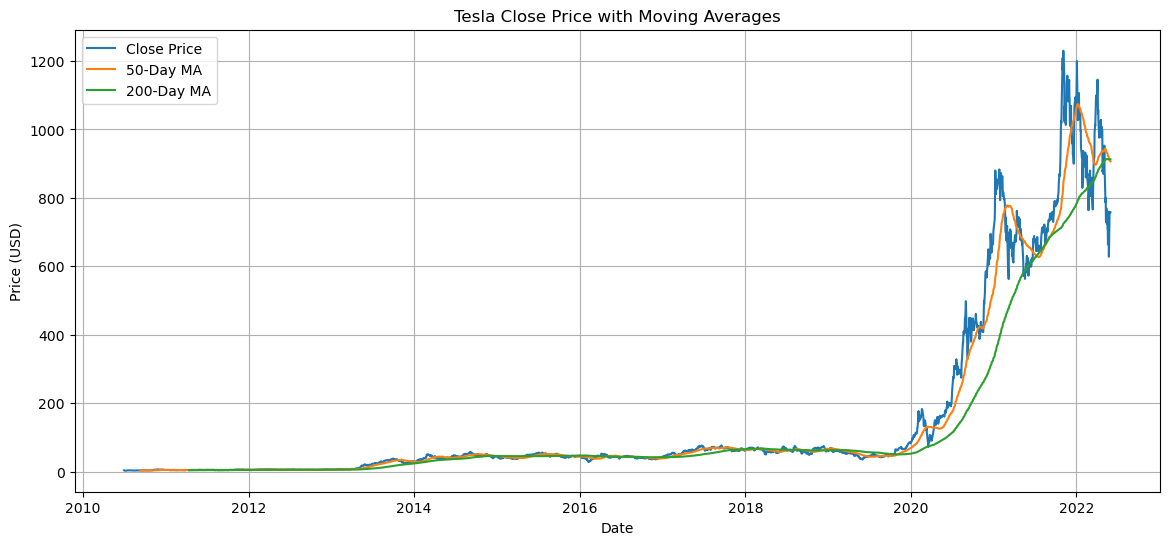

In [19]:
# Plot Closing Price with Moving Averages
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-Day MA')
plt.plot(df['MA200'], label='200-Day MA')
plt.title('Tesla Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

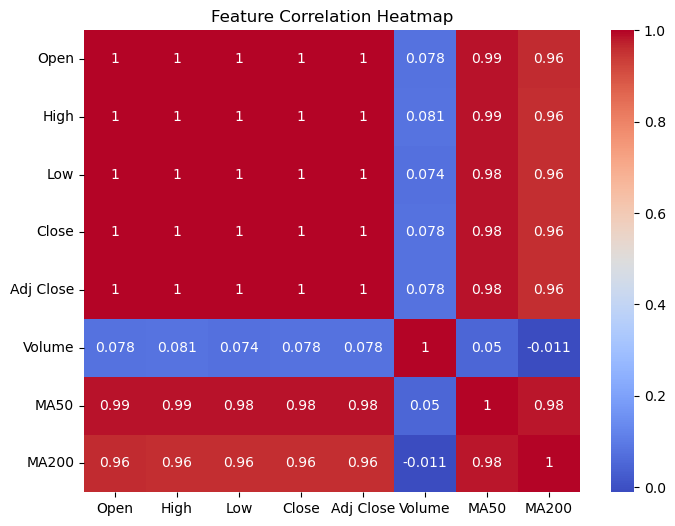

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select only the 'Close' column for now
close_data = df[['Close']]

# Apply MinMax Scaling (range 0-1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

# Convert scaled data back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, index=close_data.index, columns=['Close'])

# Preview
print(scaled_df.head())

               Close
Date                
2010-07-01  0.001004
2010-07-02  0.000554
2010-07-06  0.000051
2010-07-07  0.000000
2010-07-08  0.000271


In [25]:
def create_sequences(data, window_size):
    X = []
    y = []
    
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # previous window_size points
        y.append(data[i, 0])                # next value

    X, y = np.array(X), np.array(y)
    
    # Reshape X to be 3D as required by LSTM: (samples, time steps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

# Example usage
window_size = 60  # typically 50-100 works well for stocks
X, y = create_sequences(scaled_data, window_size)

# Check shape
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (2940, 60, 1)
y shape: (2940,)


In [27]:
# Split percentages
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

# Create splits
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# Check sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 2058
Validation size: 441
Test size: 441


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model Architecture
model = Sequential()

# First LSTM Layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
model.summary()


C:\Users\Shweta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 1.8103e-04 - val_loss: 3.3683e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 1.4568e-05 - val_loss: 3.5247e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.2046e-05 - val_loss: 2.9690e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 1.0990e-05 - val_loss: 2.8893e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 1.1838e-05 - val_loss: 2.5697e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 9.3927e-06 - val_loss: 2.2270e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 9.4442e-06 - val_loss: 2.5564e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 7.7633e-06 - val_loss: 1.9719e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 9.2202e-06 - val_loss: 1.6050e-04
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 8.2006e-06 - val_loss: 2.2680e-04
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - lo

In [33]:
# Predictions
train_pred = model.predict(X_train)
val_pred   = model.predict(X_val)
test_pred  = model.predict(X_test)

# Inverse scaling
train_pred = scaler.inverse_transform(train_pred)
val_pred   = scaler.inverse_transform(val_pred)
test_pred  = scaler.inverse_transform(test_pred)

# Inverse actual values too
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_actual   = scaler.inverse_transform(y_val.reshape(-1,1))
y_test_actual  = scaler.inverse_transform(y_test.reshape(-1,1))


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred, label):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{label} Results:")
    print(f"MSE  : {mse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%\n")

# Evaluate all sets
evaluate(y_train_actual, train_pred, "Train")
evaluate(y_val_actual, val_pred, "Validation")
evaluate(y_test_actual, test_pred, "Test")


Train Results:
MSE  : 3.7944
MAE  : 1.2778
RMSE : 1.9479
MAPE : 3.70%

Validation Results:
MSE  : 95.7651
MAE  : 5.3213
RMSE : 9.7860
MAPE : 4.71%

Test Results:
MSE  : 2934.8259
MAE  : 40.1527
RMSE : 54.1740
MAPE : 5.08%



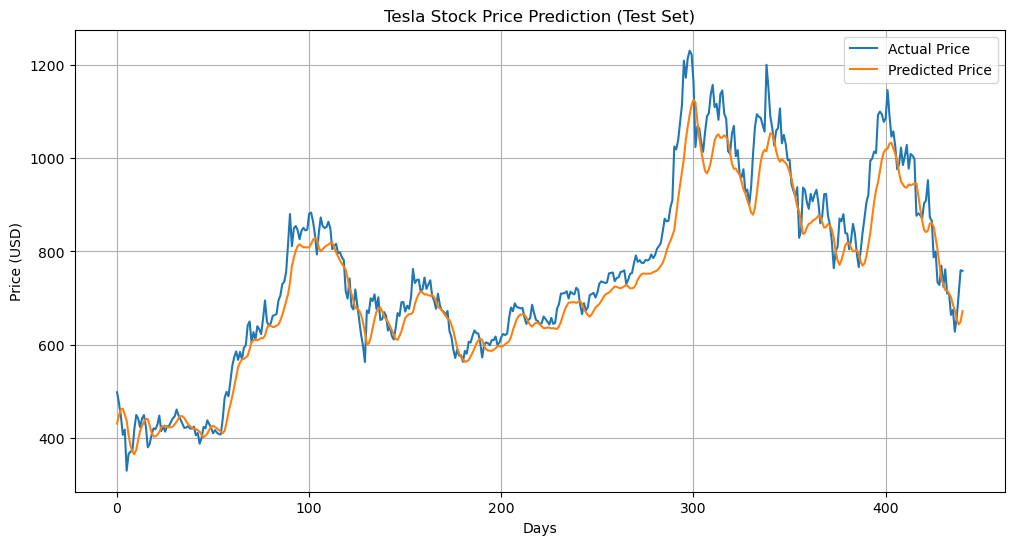

In [37]:
# Test set visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(test_pred, label='Predicted Price')
plt.title('Tesla Stock Price Prediction (Test Set)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
